In [1]:
import SpaceVis
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 100

In [3]:
Ng = 32
steps = 200
n_particles = Ng*Ng*Ng

im_x = 1080
im_y = 1080

#col_max = 120
col_max = 40
rot_z = 0

data = np.fromfile("data/small_sim.dat",dtype=np.float32)
data = data.reshape(steps+1,n_particles,3)

#data[-1] -= 16
#data[-1] *= 1.2
#data[-1] += 16

idx = 0

cam_pos = np.array([16,16,0],dtype=float)
cam_rot = np.array([0,0,rot_z],dtype=float)
rot_z += 0.01
e = np.array([0,0,10],dtype=float)
#depth_bins = np.array([[0,10],[10,20],[20,30],[30,100000]])

starts = np.arange(0,128,5)
ends = np.array(starts[1:].tolist() + [10000])
depth_bins = np.column_stack((starts,ends)).astype(np.float32)
#combined = out[0] + out[1] + out[2] + out[3]
print(len(depth_bins))

26


In [4]:
#plt.imshow(np.sum(out,axis=0),cmap="inferno",vmax=0.03,vmin=0)
#plt.axis('off')
#plt.savefig("temp/step" + str(idx) + ".jpg",bbox_inches='tight',pad_inches = 0,dpi=600)
#plt.show()

In [5]:
def get_blurs(focus_center,depth_bins,mul=30,sqr=2):
    blurs = np.abs(depth_bins[:,0] - focus_center)
    blurs /= np.max(depth_bins[:,0])
    blurs **= sqr
    blurs *= mul
    return blurs

In [6]:
def do_blurs(out,focus_center,depth_bins,mul=30,sqr=2):
    blurs = get_blurs(focus_center,depth_bins,mul,sqr)
    final = np.zeros_like(out[0])
    for i,blur in zip(out,blurs):
        if blur == 0:
            final += i
        else:
            if not (np.sum(i) == 0):
                final += SpaceVis.renderer.blur(i,15,blur)
    return final

In [7]:
blur_keyframes = ((np.linspace(0,1,30)**2)*128)[::-1]
#print(blur_keyframes)
sqr_keyframes = ((np.linspace(0,1,30)**3)+2)[::-1]
#print(sqr_keyframes)
rot_xs,rot_ys = SpaceVis.camera_shaker.get_camera_shake(len(blur_keyframes),octaves=1)
#plt.plot(rot_xs)
#plt.plot(rot_ys)
#plt.show()

In [8]:
def scale_data(data,scale):
    return (data-16)*scale + 16

In [9]:
ma = np.max(scale_data(data[-1][:,2],0.1))
mi = np.min(scale_data(data[-1][:,2],0.1))
print(ma,mi,(ma-mi)/2 + mi)

17.599937 14.400042 15.99998950958252


In [10]:
scale_keyframes = ((np.linspace(0,1,31)[1:])**2)
print(scale_keyframes)
vmax_keyframes = ((np.linspace(0,1,30)**10)*500 + 0.03)[::-1]
print(vmax_keyframes)

[0.00111111 0.00444444 0.01       0.01777778 0.02777778 0.04
 0.05444444 0.07111111 0.09       0.11111111 0.13444444 0.16
 0.18777778 0.21777778 0.25       0.28444444 0.32111111 0.36
 0.40111111 0.44444444 0.49       0.53777778 0.58777778 0.64
 0.69444444 0.75111111 0.81       0.87111111 0.93444444 1.        ]
[5.00030000e+02 3.52052432e+02 2.44726449e+02 1.67803554e+02
 1.13371802e+02 7.53833288e+01 4.92643700e+01 3.15958024e+01
 1.98536204e+01 1.21999833e+01 7.31661855e+00 4.27341079e+00
 2.42595821e+00 1.33674201e+00 7.15334533e-01 3.73771906e-01
 1.93841362e-01 1.03587235e-01 6.08259789e-02 4.18847493e-02
 3.41439558e-02 3.12761152e-02 3.03357148e-02 3.00718625e-02
 3.00116062e-02 3.00012462e-02 3.00000702e-02 3.00000012e-02
 3.00000000e-02 3.00000000e-02]


In [11]:
scale = scale_keyframes[1]
pixel_box = 100 #100
vmax_mul = 0.9418932243289341
maxs = []
for idx,blur_amount in tqdm.tqdm(enumerate(blur_keyframes),total=len(blur_keyframes)):
    cam_pos = np.array([16,16,0],dtype=float)
    cam_rot = np.array([rot_xs[idx],rot_ys[idx],0],dtype=float)
    out = SpaceVis.renderer.draw_frame(cam_pos,cam_rot,e,im_x,im_y,scale_data(data[-1],scale_keyframes[idx]),pixel_box,32,32*scale_keyframes[idx],4,4,4,depth_bins=depth_bins)
    final = do_blurs(out,blur_amount,depth_bins,sqr=sqr_keyframes[idx],mul=30)
    if idx < 10:
        this_max = np.max(final)
        maxs.append(this_max)
        plt.imshow(final,cmap="inferno",vmax=this_max * vmax_mul,vmin=0)#,vmax=0.03,vmin=0)
    else:
        plt.imshow(final,cmap="inferno",vmax=0.03,vmin=0)#,vmax=0.03,vmin=0)
    plt.axis('off')
    plt.savefig("temp/step" + str(idx) + ".jpg",bbox_inches='tight',pad_inches = 0,dpi=600)
    plt.close()

  0%|          | 0/30 [00:00<?, ?it/s]

INIT_TIME 0.000034
LOOP_TIME 15.218349


  3%|▎         | 1/30 [00:15<07:43, 16.00s/it]

INIT_TIME 0.000010
LOOP_TIME 15.373502


  7%|▋         | 2/30 [00:32<07:30, 16.08s/it]

INIT_TIME 0.000014
LOOP_TIME 15.215912


 10%|█         | 3/30 [00:48<07:12, 16.00s/it]

INIT_TIME 0.000013
LOOP_TIME 15.028532


 13%|█▎        | 4/30 [01:03<06:55, 15.96s/it]

INIT_TIME 0.000008
LOOP_TIME 14.888369


 17%|█▋        | 5/30 [01:19<06:37, 15.89s/it]

INIT_TIME 0.000010
LOOP_TIME 15.358209


 20%|██        | 6/30 [01:35<06:24, 16.00s/it]

INIT_TIME 0.000015
LOOP_TIME 15.872827


 23%|██▎       | 7/30 [01:52<06:14, 16.30s/it]

INIT_TIME 0.000012
LOOP_TIME 17.581248


 27%|██▋       | 8/30 [02:11<06:14, 17.04s/it]

INIT_TIME 0.000011
LOOP_TIME 19.248024


 30%|███       | 9/30 [02:31<06:19, 18.09s/it]

INIT_TIME 0.000010
LOOP_TIME 22.515899


 33%|███▎      | 10/30 [02:55<06:37, 19.87s/it]

INIT_TIME 0.000009
LOOP_TIME 26.945988


 37%|███▋      | 11/30 [03:23<07:05, 22.38s/it]

INIT_TIME 0.000009
LOOP_TIME 25.016798


 40%|████      | 12/30 [03:50<07:04, 23.59s/it]

INIT_TIME 0.000014
LOOP_TIME 21.811176


 43%|████▎     | 13/30 [04:13<06:39, 23.48s/it]

INIT_TIME 0.000012
LOOP_TIME 17.661558


 47%|████▋     | 14/30 [04:32<05:55, 22.21s/it]

INIT_TIME 0.000011
LOOP_TIME 15.668547


 50%|█████     | 15/30 [04:50<05:11, 20.74s/it]

INIT_TIME 0.000008
LOOP_TIME 14.619587


 53%|█████▎    | 16/30 [05:06<04:32, 19.43s/it]

INIT_TIME 0.000010
LOOP_TIME 12.801039


 57%|█████▋    | 17/30 [05:21<03:54, 18.02s/it]

INIT_TIME 0.000009
LOOP_TIME 11.326783


 60%|██████    | 18/30 [05:34<03:19, 16.64s/it]

INIT_TIME 0.000009
LOOP_TIME 10.254721


 63%|██████▎   | 19/30 [05:47<02:49, 15.41s/it]

INIT_TIME 0.000009
LOOP_TIME 8.994661


 67%|██████▋   | 20/30 [05:58<02:21, 14.17s/it]

INIT_TIME 0.000011
LOOP_TIME 8.665018


 70%|███████   | 21/30 [06:09<01:59, 13.32s/it]

INIT_TIME 0.000009
LOOP_TIME 8.472632


 73%|███████▎  | 22/30 [06:21<01:41, 12.73s/it]

INIT_TIME 0.000012
LOOP_TIME 7.983826


 77%|███████▋  | 23/30 [06:32<01:25, 12.24s/it]

INIT_TIME 0.000009
LOOP_TIME 7.628819


 80%|████████  | 24/30 [06:43<01:10, 11.82s/it]

INIT_TIME 0.000009
LOOP_TIME 6.958650


 83%|████████▎ | 25/30 [06:53<00:56, 11.36s/it]

INIT_TIME 0.000010
LOOP_TIME 6.521257


 87%|████████▋ | 26/30 [07:03<00:44, 11.01s/it]

INIT_TIME 0.000013
LOOP_TIME 6.172622


 90%|█████████ | 27/30 [07:13<00:32, 10.75s/it]

INIT_TIME 0.000012
LOOP_TIME 5.935411


 93%|█████████▎| 28/30 [07:23<00:21, 10.56s/it]

INIT_TIME 0.000012
LOOP_TIME 5.487580


 97%|█████████▋| 29/30 [07:33<00:10, 10.33s/it]

INIT_TIME 0.000011
LOOP_TIME 5.413955


100%|██████████| 30/30 [07:43<00:00, 15.44s/it]


[538.4415, 427.7132, 128.83868, 42.15513, 18.474695, 10.273699, 6.2176905, 4.0403605, 2.7375848, 1.8911787]
0.07555523397637494
0.03


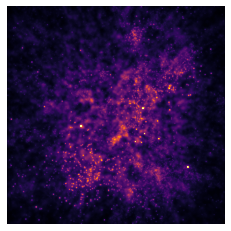

In [12]:
print(maxs)

print((0.03/np.max(final)))
print(vmax_keyframes[-1])
plt.imshow(final,cmap="inferno",vmax=0.03,vmin=0)
plt.axis('off')
#plt.savefig("temp/step" + str(idx) + ".jpg",bbox_inches='tight',pad_inches = 0,dpi=600)
plt.show()

In [13]:
layer = np.copy(out[1])

In [14]:
def blur(layer,size = 3):
    kernel = np.ones((size,size),dtype=np.float32)
    kernel /= np.sum(kernel)
    output = np.zeros_like(layer)
    for x in range(im_x):
        for y in range(im_y):
            i_count = 0
            s = 0
            for i in range(x-(size//2),x+((size//2) + 1)):
                j_count = 0
                for j in range(y-(size//2),y+((size//2) + 1)):
                    if (i >= 0) and (i < im_x):
                        if (j >=0) and (j < im_y):
                            s += kernel[i_count,j_count] * layer[i,j]
                    j_count += 1
                i_count += 1
            output[x,y] = s
    return output

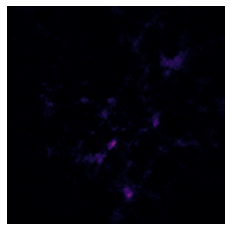

In [15]:
plt.imshow(SpaceVis.renderer.blur(out[3],10,10),cmap="inferno",vmax=0.03,vmin=0)
plt.axis('off')
#plt.savefig("temp/step" + str(idx) + ".jpg",bbox_inches='tight',pad_inches = 0,dpi=600)
plt.show()